# Face Landmark Detection with AlbumentationsX: Keypoint Label Swapping

This tutorial demonstrates a **new feature in AlbumentationsX**: **automatic keypoint label swapping during horizontal flips**.

## 🔥 The Key Feature: Label Swapping + Array Reordering

**Standard Albumentations behavior** with `HorizontalFlip`:
- ✅ Flips keypoint coordinates (x becomes width - x)

**NEW in AlbumentationsX** with `label_mapping`:
- ✅ Flips keypoint coordinates (standard)
- 🆕 **Updates keypoint labels** (e.g., "left_eye" → "right_eye")
- 🆕 **Reorders the keypoints array** to match the new labels

**Why this matters**: In face landmark detection, array index = semantic meaning:
- `keypoints[36]` = "left eye outer corner"
- `keypoints[45]` = "right eye outer corner"

After horizontal flip:
- The left eye physically moves to the right side (coordinates change)
- But semantically it's now the "right eye"
- So it should be at index 45, not 36!

**AlbumentationsX `label_mapping` does both**: changes the label AND moves the keypoint to the correct position in the array.

## What We'll Build

- Train face landmark detection using **heatmap-based regression** (U-Net)
- Use **AlbumentationsX** with `label_mapping` to handle symmetric keypoints correctly
- Compare **minimal** (HFlip only) vs **medium** (full augmentation pipeline)
- Train on **HELEN dataset** (2,330 faces with 68 landmarks)

---

## 📦 Installation

In [ ]:
%%bash
pip install torch albumentationsx opencv-python matplotlib tqdm segmentation_models_pytorch kaggle

---

## 🎯 What We'll Build

1. **Download HELEN dataset** from Kaggle (68-point face landmarks)
2. **Visualize augmentations** (minimal vs medium)
3. **Train two models** with different augmentation strategies
4. **Compare results**: loss curves, metrics, and predictions

**Key Feature**: We'll use `label_mapping` in Albumentations to **swap symmetric keypoints** (left eye ↔ right eye) during horizontal flips!

---

## 📚 Imports and Setup

**Note**: This notebook uses `num_workers=0` in DataLoader for Jupyter compatibility. If you're running this as a Python script, you can use `num_workers=4` for faster data loading.

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

# Reproducibility
SEED = 137
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device setup
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

Using MPS (Apple Silicon)


---

## 📥 Dataset Download

We'll use the HELEN dataset from Kaggle with 68 facial landmarks.

**Prerequisites**:
1. Install kaggle: `pip install kaggle`
2. Get API token: https://www.kaggle.com/docs/api
3. Accept dataset terms: https://www.kaggle.com/datasets/vietpro/helen-with-68-facial-landmarks

In [ ]:
def download_kaggle_helen(data_dir="data"):
    """Download HELEN dataset with 68 facial landmarks from Kaggle."""
    try:
        import kaggle
    except ImportError:
        print("Please install kaggle: pip install kaggle")
        return False
    
    data_path = Path(data_dir)
    download_path = data_path / "helen_raw"
    
    try:
        # Download from Kaggle
        print("Downloading HELEN dataset...")
        kaggle.api.dataset_download_files(
            'vietpro/helen-with-68-facial-landmarks',
            path=str(download_path),
            unzip=True
        )
        
        # Find image and landmark files
        img_files = list(download_path.glob("*.jpg"))
        if not img_files:
            print("No images found in downloaded dataset")
            return False
        
        print(f"Found {len(img_files)} images")
        
        # Process files
        samples = []
        for img_file in tqdm(img_files, desc="Processing"):
            pts_file = img_file.with_suffix('.pts')
            if not pts_file.exists():
                continue
            
            # Read image
            image = cv2.imread(str(img_file))
            if image is None:
                continue
            
            # Read landmarks from .pts file
            with open(pts_file, 'r') as f:
                lines = f.readlines()
            
            # Parse coordinates (skip header lines)
            coords = []
            for line in lines:
                line = line.strip()
                if not line or line.startswith(('#', '//', 'version', 'n_points', '{', '}')):
                    continue
                parts = line.split()
                if len(parts) >= 2:
                    coords.append([float(parts[0]), float(parts[1])])
            
            if len(coords) != 68:
                continue
            
            landmarks = np.array(coords, dtype=np.float32)  # [68, 2] as [x, y]
            
            # Sanity check: landmarks should be within image bounds
            h, w = image.shape[:2]
            if landmarks[:, 0].max() > w or landmarks[:, 1].max() > h:
                # Try swapping if needed
                if landmarks[:, 1].max() <= w and landmarks[:, 0].max() <= h:
                    landmarks = landmarks[:, [1, 0]]
                else:
                    continue
            
            samples.append((img_file.name, image, landmarks))
        
        if len(samples) == 0:
            print("No valid samples found")
            return False
        
        print(f"\n✓ Processed {len(samples)} samples")
        
        # Shuffle and split 90/10
        rng = np.random.RandomState(SEED)
        rng.shuffle(samples)
        n_val = len(samples) // 10
        n_train = len(samples) - n_val
        
        train_samples = samples[:n_train]
        val_samples = samples[n_train:]
        
        # Save training set
        train_img_dir = data_path / "train" / "images"
        train_lm_dir = data_path / "train" / "landmarks"
        train_img_dir.mkdir(parents=True, exist_ok=True)
        train_lm_dir.mkdir(parents=True, exist_ok=True)
        
        for i, (name, img, lm) in enumerate(tqdm(train_samples, desc="Saving train")):
            cv2.imwrite(str(train_img_dir / f"face_{i:04d}.jpg"), img)
            np.save(train_lm_dir / f"face_{i:04d}.npy", lm)
        
        # Save validation set
        val_img_dir = data_path / "val" / "images"
        val_lm_dir = data_path / "val" / "landmarks"
        val_img_dir.mkdir(parents=True, exist_ok=True)
        val_lm_dir.mkdir(parents=True, exist_ok=True)
        
        for i, (name, img, lm) in enumerate(tqdm(val_samples, desc="Saving val")):
            cv2.imwrite(str(val_img_dir / f"face_{i:04d}.jpg"), img)
            np.save(val_lm_dir / f"face_{i:04d}.npy", lm)
        
        print(f"\n✓ Dataset ready: {n_train} train, {n_val} val")
        return True
        
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        return False

# Download dataset
DATA_DIR = "data"
TRAIN_IMAGES_DIR = f"{DATA_DIR}/train/images"

if not Path(TRAIN_IMAGES_DIR).exists() or len(list(Path(TRAIN_IMAGES_DIR).glob("*"))) == 0:
    print("Downloading HELEN dataset from Kaggle...")
    success = download_kaggle_helen(DATA_DIR)
    if not success:
        print("❌ Failed to download. Please check Kaggle API setup.")
else:
    print("✓ Dataset already exists")

✓ Dataset already exists


---

## 🎬 Demo: HorizontalFlip with Label Mapping

Let's first see the **key feature in action** before diving into the full pipeline!

This demo shows how AlbumentationsX's `label_mapping` feature handles symmetric keypoints during horizontal flip.

/var/folders/68/k137nch11m76w1plfrw320r00000gn/T/ipykernel_41812/1241002483.py:135: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/68/k137nch11m76w1plfrw320r00000gn/T/ipykernel_41812/1241002483.py:135: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/albumentations_examples/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/albumentations_examples/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


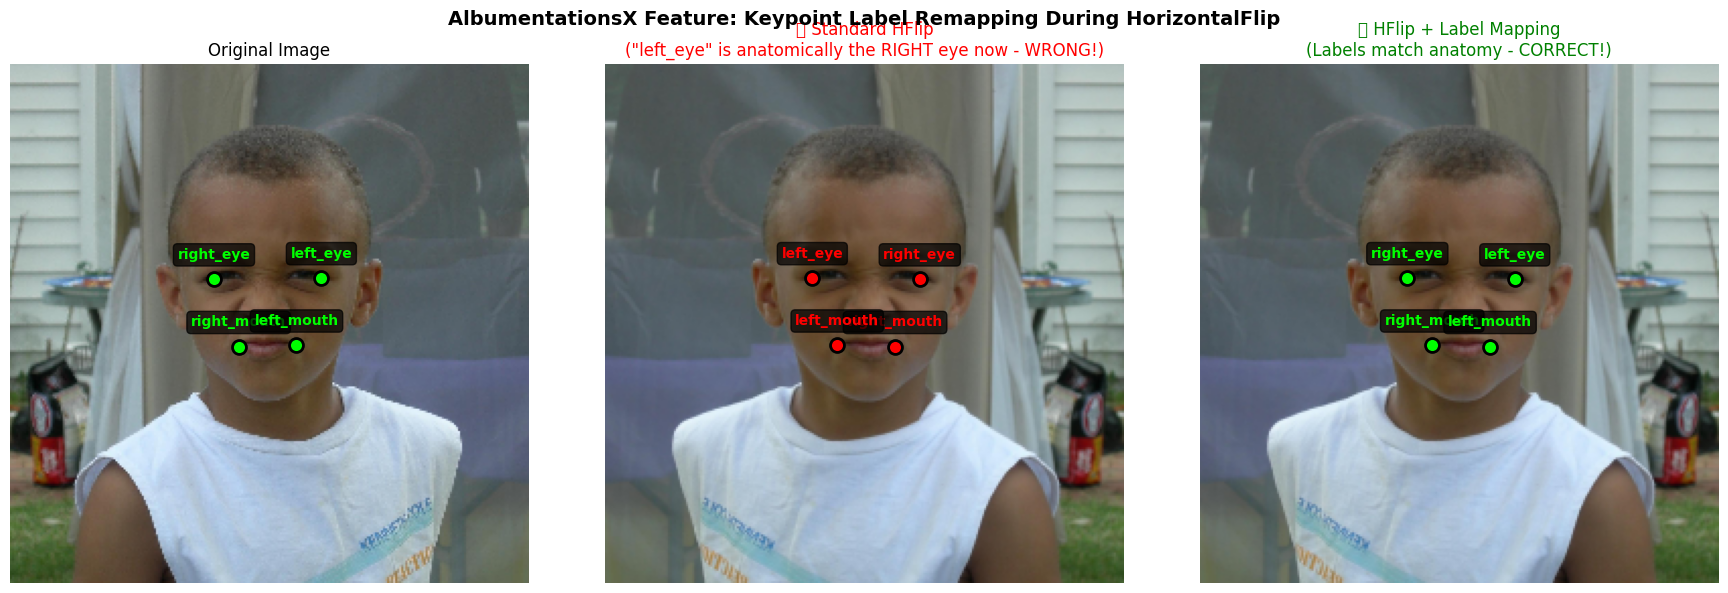


WHAT HAPPENED:

Original image:
  - 'left_eye' (idx 36):  at pixel (100, 106)
  - 'right_eye' (idx 45): at pixel (153, 105)

❌ Standard HFlip (PROBLEM):
  - 'left_eye' label: at pixel (155, 106)
  - 'right_eye' label: at pixel (102, 105)
  ⚠️ After flip, 'left_eye' is anatomically the RIGHT eye of flipped person - labels are WRONG!

✅ HFlip + Label Mapping (FIXED):
  - 'left_eye' label: at pixel (102, 105)
  - 'right_eye' label: at pixel (155, 106)

  Explanation:
    - Original array[36] ('left_eye') → swapped to array[45] ('right_eye')
    - Original array[45] ('right_eye') → swapped to array[36] ('left_eye')
    - Now 'left_eye' label points to the person's anatomical left eye in flipped image!
  ✓ Labels are anatomically correct for the flipped person!


In [ ]:
# Load one sample image for demonstration
DATA_DIR = "data"
np.random.seed(SEED)
all_images = sorted(list(Path(f"{DATA_DIR}/train/images").glob("*.jpg")))
sample_idx = np.random.randint(0, len(all_images))
sample_image_path = all_images[sample_idx]
sample_landmark_path = Path(f"{DATA_DIR}/train/landmarks") / f"{sample_image_path.stem}.npy"

# Load image and landmarks
image = cv2.imread(str(sample_image_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
landmarks = np.load(sample_landmark_path)

# Select a few key points to visualize labels
# Note: "left" and "right" are ANATOMICAL (person's left/right, mirrored for viewer)
# When person looks at themselves: their left eye appears on RIGHT side of image to viewer
label_points = {
    36: 'right_eye',   # Person's RIGHT eye → appears on LEFT side of image for viewer
    45: 'left_eye',    # Person's LEFT eye → appears on RIGHT side of image for viewer
    48: 'right_mouth', # Person's RIGHT mouth → appears on LEFT side for viewer
    54: 'left_mouth'   # Person's LEFT mouth → appears on RIGHT side for viewer
}

# Create transform WITHOUT label mapping (standard Albumentations)
transform_standard = A.Compose([
    A.Resize(256, 256, interpolation=cv2.INTER_CUBIC, area_for_downscale="image"),
    A.HorizontalFlip(p=1.0),  # Always flip for demo
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False), strict=True, seed=SEED)

# Create transform WITH label mapping (AlbumentationsX feature)
# First, let's define a simple mapping just for the key points
FACE_68_HFLIP_MAPPING = {
    # Jawline (0-16): mirror across center
    0: 16, 1: 15, 2: 14, 3: 13, 4: 12, 5: 11, 6: 10, 7: 9, 8: 8,
    16: 0, 15: 1, 14: 2, 13: 3, 12: 4, 11: 5, 10: 6, 9: 7,
    # Eyebrows: left (17-21) ↔ right (22-26)
    17: 26, 18: 25, 19: 24, 20: 23, 21: 22,
    26: 17, 25: 18, 24: 19, 23: 20, 22: 21,
    # Nose bridge (27-30): no swap (central)
    27: 27, 28: 28, 29: 29, 30: 30,
    # Nose bottom: left (31-32) ↔ right (34-35), center (33)
    31: 35, 32: 34, 33: 33, 34: 32, 35: 31,
    # Eyes: left (36-41) ↔ right (42-47)
    36: 45, 37: 44, 38: 43, 39: 42, 40: 47, 41: 46,
    45: 36, 44: 37, 43: 38, 42: 39, 47: 40, 46: 41,
    # Outer lips: left ↔ right, keep centers
    48: 54, 49: 53, 50: 52, 51: 51,
    54: 48, 53: 49, 52: 50,
    55: 59, 56: 58, 57: 57,
    59: 55, 58: 56,
    # Inner lips: left ↔ right, keep centers
    60: 64, 61: 63, 62: 62,
    64: 60, 63: 61,
    65: 67, 66: 66,
    67: 65,
}

transform_with_mapping = A.Compose([
    A.Resize(256, 256, interpolation=cv2.INTER_CUBIC, area_for_downscale="image"),
    A.HorizontalFlip(p=1.0),  # Always flip for demo
], keypoint_params=A.KeypointParams(
    format='xy', 
    label_fields=['keypoint_labels'],
    remove_invisible=False,
    label_mapping={'HorizontalFlip': {'keypoint_labels': FACE_68_HFLIP_MAPPING}}
), strict=True, seed=SEED)

# Apply standard transform
keypoint_labels = np.arange(68)  # 0, 1, 2, ..., 67
result_standard = transform_standard(image=image.copy(), keypoints=landmarks)
image_standard = result_standard['image']
kpts_standard = np.array(result_standard['keypoints'])

# Apply transform with label mapping
result_mapped = transform_with_mapping(
    image=image.copy(), 
    keypoints=landmarks,
    keypoint_labels=keypoint_labels
)
image_mapped = result_mapped['image']
kpts_mapped = np.array(result_mapped['keypoints'])
labels_mapped = np.array(result_mapped['keypoint_labels'])

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original
ax = axes[0]
ax.imshow(cv2.resize(image, (256, 256)))
resized_landmarks = landmarks * (256 / image.shape[1])  # Simple resize
for idx, label_name in label_points.items():
    x, y = resized_landmarks[idx]
    ax.scatter(x, y, c='lime', s=100, edgecolors='black', linewidths=2)
    ax.text(x, y-10, label_name, fontsize=10, color='lime', weight='bold',
            ha='center', bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
ax.set_title('Original Image', fontsize=12)
ax.axis('off')

# Standard HFlip (coordinates flipped, but labels stay the same!)
ax = axes[1]
ax.imshow(image_standard)
for idx, label_name in label_points.items():
    x, y = kpts_standard[idx]  # WRONG: "left_eye" is now physically on the right!
    color = 'red'
    ax.scatter(x, y, c=color, s=100, edgecolors='black', linewidths=2)
    ax.text(x, y-10, label_name, fontsize=10, color=color, weight='bold',
            ha='center', bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
ax.set_title('❌ Standard HFlip\n("left_eye" is anatomically the RIGHT eye now - WRONG!)', fontsize=12, color='red')
ax.axis('off')

# With label mapping (coordinates AND labels swapped!)
ax = axes[2]
ax.imshow(image_mapped)
# Create reverse mapping to find which label is at each position
idx_to_label = {}
for idx, label_name in label_points.items():
    # Find where this label ended up after mapping
    mapped_idx = labels_mapped[idx]
    idx_to_label[int(mapped_idx)] = label_name

for orig_idx, label_name in label_points.items():
    # After mapping, find where this label ended up
    new_idx = int(labels_mapped[orig_idx])
    x, y = kpts_mapped[new_idx]
    color = 'lime'
    ax.scatter(x, y, c=color, s=100, edgecolors='black', linewidths=2)
    # Show the semantic label (it's now in the correct position!)
    ax.text(x, y-10, label_name, fontsize=10, color=color, weight='bold',
            ha='center', bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
ax.set_title('✅ HFlip + Label Mapping\n(Labels match anatomy - CORRECT!)', fontsize=12, color='green')
ax.axis('off')

plt.suptitle('AlbumentationsX Feature: Keypoint Label Remapping During HorizontalFlip', 
             fontsize=14, weight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Print what happened
print("\n" + "="*70)
print("WHAT HAPPENED:")
print("="*70)
print("\nOriginal image:")
print(f"  - 'left_eye' (idx 36):  at pixel ({resized_landmarks[36][0]:.0f}, {resized_landmarks[36][1]:.0f})")
print(f"  - 'right_eye' (idx 45): at pixel ({resized_landmarks[45][0]:.0f}, {resized_landmarks[45][1]:.0f})")

print("\n❌ Standard HFlip (PROBLEM):")
print(f"  - 'left_eye' label: at pixel ({kpts_standard[36][0]:.0f}, {kpts_standard[36][1]:.0f})")
print(f"  - 'right_eye' label: at pixel ({kpts_standard[45][0]:.0f}, {kpts_standard[45][1]:.0f})")
print("  ⚠️ After flip, 'left_eye' is anatomically the RIGHT eye of flipped person - labels are WRONG!")

print("\n✅ HFlip + Label Mapping (FIXED):")
# Find where left_eye and right_eye labels ended up
left_eye_new_idx = int(labels_mapped[36])
right_eye_new_idx = int(labels_mapped[45])
print(f"  - 'left_eye' label: at pixel ({kpts_mapped[left_eye_new_idx][0]:.0f}, {kpts_mapped[left_eye_new_idx][1]:.0f})")
print(f"  - 'right_eye' label: at pixel ({kpts_mapped[right_eye_new_idx][0]:.0f}, {kpts_mapped[right_eye_new_idx][1]:.0f})")
print(f"\n  Explanation:")
print(f"    - Original array[36] ('left_eye') → swapped to array[{FACE_68_HFLIP_MAPPING[36]}] ('right_eye')")
print(f"    - Original array[45] ('right_eye') → swapped to array[{FACE_68_HFLIP_MAPPING[45]}] ('left_eye')")
print(f"    - Now 'left_eye' label points to the person's anatomical left eye in flipped image!")
print("  ✓ Labels are anatomically correct for the flipped person!")
print("="*70)

**Key Insight**: 

Labels are from the **person's perspective** (their left/right, not viewer's):

- **Original**: `left_eye` (label #36) = person's left eye → appears on RIGHT side for viewer
- **After standard flip**: Image is mirrored, so the person's left eye is now on the LEFT side for viewer

**Without `label_mapping`** ❌:
- Coordinates flip, but labels stay the same
- Label #36 (`left_eye`) is now on the LEFT side for viewer
- **Problem**: That physical eye is now the person's RIGHT eye in the flipped image, but still labeled as "left_eye"!

**With `label_mapping`** ✅:
- Coordinates flip AND labels swap: 36 ↔ 45
- After flip, what's on the LEFT for viewer gets label #45 (`right_eye`) - anatomically correct!
- After flip, what's on the RIGHT for viewer gets label #36 (`left_eye`) - anatomically correct!
- **Correct**: Labels match the anatomy of the person in the flipped image!

**Why this matters**: Think of the flipped image as a different person. Their left eye should be labeled "left_eye", not based on where it was before flipping, but based on the anatomy in the final image.

---

## 🔑 Using the Mapping in Your Pipeline

The `FACE_68_HFLIP_MAPPING` dictionary is already defined above. Now we'll use it in our augmentation pipelines!

---

## 🎨 Augmentation Pipelines

We'll define two augmentation strategies:
- **Minimal**: Just `HorizontalFlip` with `label_mapping` (demonstrates the core feature!)
- **Medium**: Full augmentation pipeline (HFlip + dropout + affine + color + compression + blur + noise)

In [ ]:
def get_train_transforms(image_size=256, aug_type="medium"):
    """Get training augmentation pipeline."""
    # area_for_downscale="image": uses cv2.INTER_AREA for downscaling, cv2.INTER_CUBIC otherwise (reduces artifacts)
    base = [A.Resize(image_size, image_size, interpolation=cv2.INTER_CUBIC, area_for_downscale="image")]
    
    if aug_type == "minimal":
        # Minimal: HorizontalFlip with label swapping (demonstrates the key feature!)
        augs = [
            A.HorizontalFlip(p=0.5),
        ]
        label_mapping = {
            'HorizontalFlip': {
                'keypoint_labels': FACE_68_HFLIP_MAPPING
            }
        }
    
    elif aug_type == "medium":
        # Balanced augmentations with keypoint label swapping
        augs = [
            # Basic geometric (with label swapping for symmetric keypoints!)
            A.HorizontalFlip(p=0.5),
            
            # Dropout/Occlusion (HIGH IMPACT - teaches robustness to occlusions)
            A.CoarseDropout(
                num_holes_range=(1, 5),
                hole_height_range=(0.05, 0.15),  # 5-15% of image size
                hole_width_range=(0.05, 0.15),
                fill=0,
                p=0.3
            ),
            
            # Affine transformations
            A.Affine(
                scale=(0.8, 1.2),
                rotate=(-20, 20),
                keep_ratio=True,
                p=0.7
            ),
            
            # Color augmentations (realistic lighting conditions)
            A.OneOf([
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0),
                A.PlanckianJitter(mode='blackbody', p=1.0),  # Realistic temperature shifts
            ], p=0.5),
            
            # Image quality degradation (JPEG compression)
            A.ImageCompression(quality_range=(50, 95), compression_type='jpeg', p=0.3),
            
            # Blur and noise (camera effects)
            A.GaussNoise(std_range=(0.02, 0.1), p=0.3),
            A.OneOf([
                A.Blur(blur_limit=3, p=1.0),
                A.MedianBlur(blur_limit=3, p=1.0),
            ], p=0.2),
        ]
        label_mapping = {
            'HorizontalFlip': {
                'keypoint_labels': FACE_68_HFLIP_MAPPING
            }
        }
    else:
        raise ValueError(f"Unknown aug_type: {aug_type}")
    
    # Normalization and tensor conversion (always applied)
    post = [
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.ToTensorV2(),
    ]
    
    return A.Compose(
        base + augs + post,
        keypoint_params=A.KeypointParams(
            format='xy',
            label_fields=['keypoint_labels'] if label_mapping else None,
            remove_invisible=False,
            label_mapping=label_mapping
        ),
        strict=True,
        seed=SEED
    )


def get_val_transforms(image_size=256):
    """Validation transforms (no augmentation)."""
    return A.Compose([
        A.Resize(image_size, image_size, interpolation=cv2.INTER_CUBIC, area_for_downscale="image"),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.ToTensorV2(),
    ], keypoint_params=A.KeypointParams(
        format='xy',
        label_fields=['keypoint_labels'],
        remove_invisible=False,
        label_mapping={}  # Empty mapping to suppress warning (no label swapping in validation)
    ), strict=True, seed=SEED)

---

## 👁️ Visualize Augmentations

Let's see how **minimal** vs **medium** augmentations look on real faces!

MINIMAL Augmentation
Just HorizontalFlip with label_mapping (keypoint reordering)
Notice how symmetric keypoints swap positions correctly!


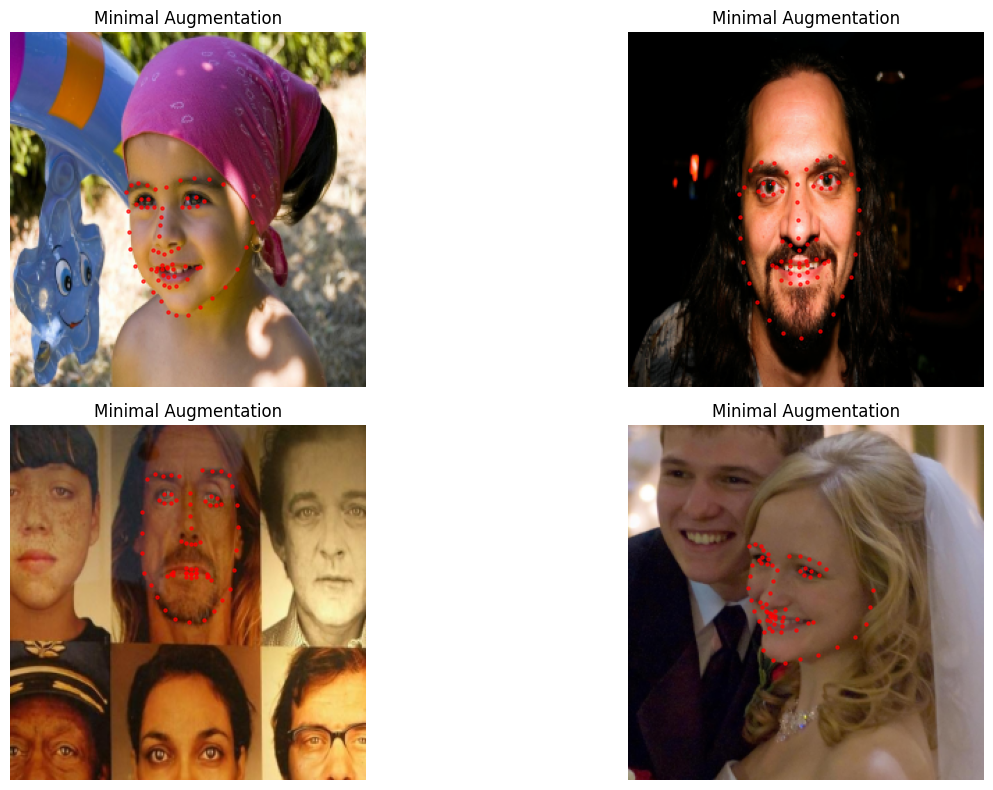


MEDIUM Augmentation
Full pipeline: HFlip + CoarseDropout + Affine + Color + Compression + Blur + Noise


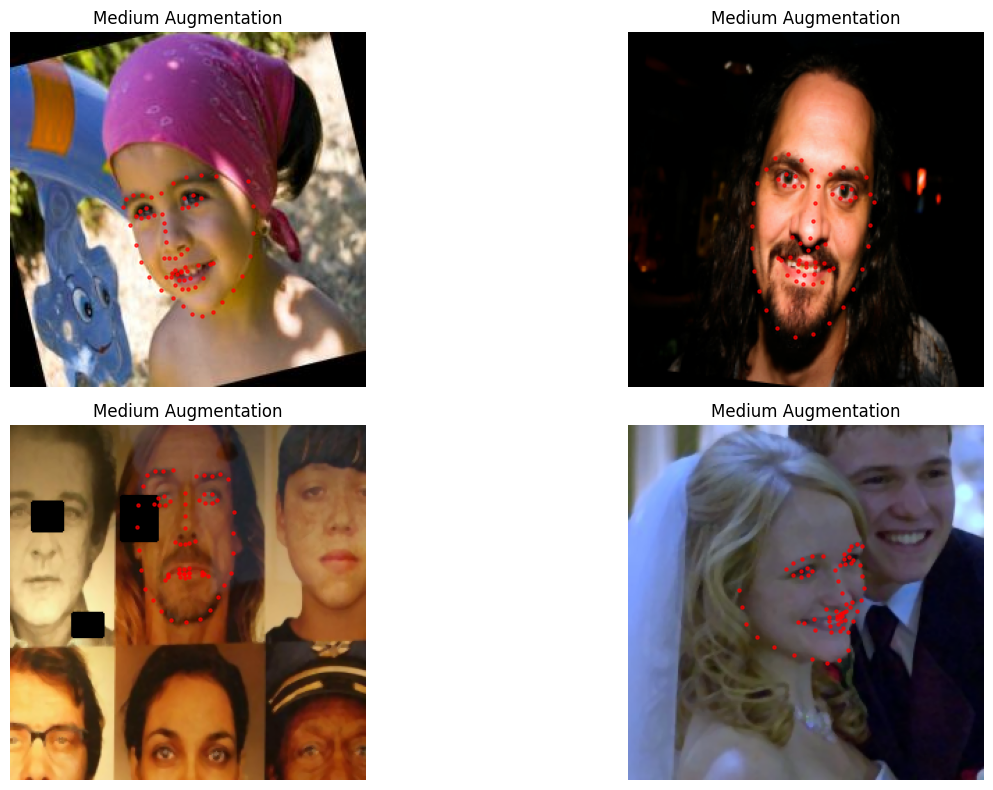

In [ ]:
class FaceLandmarkDataset(Dataset):
    """Dataset for face landmarks."""
    def __init__(self, images_dir, landmarks_dir, transform=None, image_size=256):
        self.images_dir = Path(images_dir)
        self.landmarks_dir = Path(landmarks_dir)
        self.transform = transform
        self.image_size = image_size
        self.image_files = sorted(list(self.images_dir.glob("*.jpg")) + 
                                  list(self.images_dir.glob("*.png")))
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image and landmarks
        img_path = self.image_files[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        landmark_path = self.landmarks_dir / f"{img_path.stem}.npy"
        landmarks = np.load(landmark_path).astype(np.float32)  # [68, 2]
        
        # Create keypoint labels for label swapping
        keypoint_labels = np.arange(len(landmarks))
        
        # Apply augmentations
        transformed = self.transform(
            image=image,
            keypoints=landmarks,
            keypoint_labels=keypoint_labels
        )
        
        image = transformed["image"]
        landmarks = transformed["keypoints"]
        landmarks_tensor = torch.from_numpy(np.array(landmarks, dtype=np.float32))
        
        return image, landmarks_tensor


def visualize_augmentations(aug_type, num_samples=4):
    """Visualize how augmentations affect the images."""
    dataset = FaceLandmarkDataset(
        f"{DATA_DIR}/train/images",
        f"{DATA_DIR}/train/landmarks",
        transform=get_train_transforms(256, aug_type),
        image_size=256
    )
    
    fig, axes = plt.subplots(2, num_samples // 2, figsize=(15, 8))
    axes = axes.flatten()
    
    np.random.seed(SEED)
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for idx, ax in zip(indices, axes):
        image, landmarks = dataset[idx]
        
        # Denormalize image for display
        image_np = image.permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = np.clip(image_np * std + mean, 0, 1)
        
        ax.imshow(image_np)
        ax.scatter(landmarks[:, 0], landmarks[:, 1], c='red', s=5, alpha=0.7)
        ax.axis('off')
        ax.set_title(f'{aug_type.capitalize()} Augmentation')
    
    plt.tight_layout()
    plt.show()

# Visualize minimal augmentation (HFlip with label swapping)
print("=" * 60)
print("MINIMAL Augmentation")
print("=" * 60)
print("Just HorizontalFlip with label_mapping (keypoint reordering)")
print("Notice how symmetric keypoints swap positions correctly!")
visualize_augmentations("minimal", num_samples=4)

# Visualize medium augmentation
print("\n" + "=" * 60)
print("MEDIUM Augmentation")
print("=" * 60)
print("Full pipeline: HFlip + CoarseDropout + Affine + Color + Compression + Blur + Noise")
visualize_augmentations("medium", num_samples=4)

---

## 🏗️ Model Architecture

We'll use a **U-Net with ResNet50 encoder** to predict **heatmaps** for each landmark.

### Model Definition

In [ ]:
class HeatmapModel(nn.Module):
    """U-Net model for heatmap-based landmark detection."""
    def __init__(self, num_keypoints=68, heatmap_size=256, encoder_name="resnet50"):
        super().__init__()
        self.heatmap_size = heatmap_size
        
        # U-Net from segmentation_models_pytorch
        self.unet = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=3,
            classes=num_keypoints,
            decoder_channels=(256, 128, 64, 32, 16),
            activation=None,
        )
    
    def forward(self, x):
        heatmaps = self.unet(x)
        
        # Resize if needed
        if self.heatmap_size != x.shape[-1]:
            heatmaps = nn.functional.interpolate(
                heatmaps,
                size=(self.heatmap_size, self.heatmap_size),
                mode='bilinear',
                align_corners=False
            )
        
        return heatmaps

### Heatmap Generation

In [ ]:
def generate_heatmaps(landmarks, image_size=256, heatmap_size=256, sigma=8.0):
    """Generate Gaussian heatmaps from landmark coordinates."""
    B, K, _ = landmarks.shape
    device = landmarks.device
    H = W = heatmap_size
    
    # Scale landmarks to heatmap size
    scale = heatmap_size / image_size
    landmarks_scaled = landmarks * scale
    
    # Create coordinate grids
    x = torch.arange(W, device=device, dtype=torch.float32)
    y = torch.arange(H, device=device, dtype=torch.float32)
    yy, xx = torch.meshgrid(y, x, indexing='ij')
    
    # Generate Gaussians
    cx = landmarks_scaled[:, :, 0].view(B, K, 1, 1)
    cy = landmarks_scaled[:, :, 1].view(B, K, 1, 1)
    
    return torch.exp(-((xx - cx)**2 + (yy - cy)**2) / (2 * sigma**2))

### Coordinate Extraction from Heatmaps

In [ ]:
def soft_argmax_2d(heatmaps, temperature=1.0):
    """Extract sub-pixel coordinates from heatmaps using differentiable soft-argmax."""
    B, K, H, W = heatmaps.shape
    device = heatmaps.device
    
    # Flatten and apply softmax
    heatmaps_flat = heatmaps.view(B, K, -1) / temperature
    probs = torch.softmax(heatmaps_flat, dim=-1)
    
    # Create coordinate grids
    x_coords = torch.arange(W, device=device, dtype=torch.float32)
    y_coords = torch.arange(H, device=device, dtype=torch.float32)
    yy, xx = torch.meshgrid(y_coords, x_coords, indexing='ij')
    
    xx = xx.flatten()
    yy = yy.flatten()
    
    # Weighted sum: E[x] = Σ(x * p(x))
    x = (probs * xx.view(1, 1, -1)).sum(dim=-1)
    y = (probs * yy.view(1, 1, -1)).sum(dim=-1)
    
    return torch.stack([x, y], dim=-1)

### Loss Function

In [ ]:
class WingLoss(nn.Module):
    """Wing Loss for robust coordinate regression."""
    def __init__(self, omega=10, epsilon=2):
        super().__init__()
        self.omega = omega
        self.epsilon = epsilon
        self.C = self.omega - self.omega * np.log(1 + self.omega / self.epsilon)
    
    def forward(self, pred, target):
        delta = (target - pred).abs()
        loss = torch.where(
            delta < self.omega,
            self.omega * torch.log(1 + delta / self.epsilon),
            delta - self.C
        )
        return loss.mean()

---

## 🎓 Training Functions

### Training Loop (One Epoch)

In [ ]:
def train_epoch(model, dataloader, heatmap_criterion, coord_criterion, optimizer, device, epoch, 
                image_size=256, heatmap_size=256, coord_loss_weight=0.1):
    """Train for one epoch."""
    model.train()
    running_total_loss = 0.0
    running_heatmap_loss = 0.0
    running_coord_loss = 0.0
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for images, landmarks in pbar:
        images = images.to(device)
        landmarks = landmarks.to(device)
        
        optimizer.zero_grad()
        
        # Generate target heatmaps
        target_heatmaps = generate_heatmaps(landmarks, image_size, heatmap_size, sigma=8.0)
        
        # Forward pass
        pred_heatmaps = model(images)
        heatmap_loss = heatmap_criterion(pred_heatmaps, target_heatmaps)
        
        # Auxiliary coordinate loss
        pred_coords = soft_argmax_2d(pred_heatmaps)
        scale = image_size / heatmap_size
        pred_coords_pixels = pred_coords * scale
        coord_loss = coord_criterion(pred_coords_pixels, landmarks)
        
        # Combined loss
        total_loss = heatmap_loss + coord_loss_weight * coord_loss
        total_loss.backward()
        optimizer.step()
        
        running_total_loss += total_loss.item()
        running_heatmap_loss += heatmap_loss.item()
        running_coord_loss += coord_loss.item()
        
        pbar.set_postfix({
            'total': f'{total_loss.item():.4f}',
            'heatmap': f'{heatmap_loss.item():.4f}',
            'coord': f'{coord_loss.item():.2f}'
        })
    
    return (running_total_loss / len(dataloader), 
            running_heatmap_loss / len(dataloader),
            running_coord_loss / len(dataloader))

### Validation Function

In [ ]:
def validate(model, dataloader, criterion, device, image_size=256, heatmap_size=256):
    """Validate model: returns (heatmap_loss, mean_pixel_error, nme_percentage)."""
    model.eval()
    running_loss = 0.0
    total_pixel_error = 0.0
    total_nme = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for images, landmarks in tqdm(dataloader, desc="Validating", leave=False):
            images = images.to(device)
            landmarks = landmarks.to(device)
            
            # Generate target heatmaps and compute loss
            target_heatmaps = generate_heatmaps(landmarks, image_size, heatmap_size, sigma=8.0)
            pred_heatmaps = model(images)
            loss = criterion(pred_heatmaps, target_heatmaps)
            running_loss += loss.item()
            
            # Extract coordinates and compute metrics
            pred_coords_heatmap = soft_argmax_2d(pred_heatmaps)
            pred_coords_pixels = pred_coords_heatmap * (image_size / heatmap_size)
            
            # Pixel error
            pixel_errors = torch.norm(pred_coords_pixels - landmarks, dim=-1)
            total_pixel_error += pixel_errors.mean().item() * images.shape[0]
            
            # NME (normalized by inter-ocular distance: landmarks 36 and 45)
            inter_ocular = torch.norm(landmarks[:, 36] - landmarks[:, 45], dim=-1)
            nme = (pixel_errors.mean(dim=1) / inter_ocular * 100).mean().item()
            total_nme += nme * images.shape[0]
            
            num_samples += images.shape[0]
    
    return running_loss / len(dataloader), total_pixel_error / num_samples, total_nme / num_samples

### Visualization Function

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=4, image_size=256, heatmap_size=256):
    """Visualize model predictions."""
    model.eval()
    fig, axes = plt.subplots(2, num_samples // 2, figsize=(15, 8))
    axes = axes.flatten()
    
    np.random.seed(SEED)
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    with torch.no_grad():
        for idx, ax in zip(indices, axes):
            image, landmarks_gt = dataset[idx]
            
            # Get prediction
            image_input = image.unsqueeze(0).to(device)
            pred_heatmaps = model(image_input)
            
            # Extract coordinates
            pred_coords_heatmap = soft_argmax_2d(pred_heatmaps)
            scale = image_size / heatmap_size
            landmarks_pred = pred_coords_heatmap.squeeze(0).cpu() * scale
            landmarks_gt = landmarks_gt.cpu()
            
            # Denormalize image
            image_np = image.permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = np.clip(image_np * std + mean, 0, 1)
            
            ax.imshow(image_np)
            ax.scatter(landmarks_gt[:, 0], landmarks_gt[:, 1], c='green', s=10, label='GT')
            ax.scatter(landmarks_pred[:, 0], landmarks_pred[:, 1], c='red', s=10, marker='x', label='Pred')
            ax.axis('off')
            if idx == indices[0]:
                ax.legend()
    
    plt.tight_layout()
    plt.show()

---

## 🚀 Training Loop

In [ ]:
def train_model(aug_type="minimal", num_epochs=150):
    """Train model with specified augmentation type."""
    print(f"\n{'='*60}")
    print(f"Training with {aug_type.upper()} augmentation")
    print(f"{'='*60}\n")
    
    # Hyperparameters
    IMAGE_SIZE = 256
    HEATMAP_SIZE = 256
    NUM_KEYPOINTS = 68
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-3
    
    # Create datasets
    train_dataset = FaceLandmarkDataset(
        f"{DATA_DIR}/train/images",
        f"{DATA_DIR}/train/landmarks",
        transform=get_train_transforms(IMAGE_SIZE, aug_type),
        image_size=IMAGE_SIZE
    )
    val_dataset = FaceLandmarkDataset(
        f"{DATA_DIR}/val/images",
        f"{DATA_DIR}/val/landmarks",
        transform=get_val_transforms(IMAGE_SIZE),
        image_size=IMAGE_SIZE
    )
    print(f"Dataset: {len(train_dataset)} train, {len(val_dataset)} val")
    
    # DataLoaders (num_workers=0 for Jupyter compatibility)
    # In a regular Python script, you can use num_workers=4 for faster loading
    g = torch.Generator().manual_seed(SEED)
    
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=0, generator=g
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0
    )
    
    # Create model
    model = HeatmapModel(
        num_keypoints=NUM_KEYPOINTS,
        heatmap_size=HEATMAP_SIZE,
        encoder_name="resnet50"
    ).to(device)
    
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Model: U-Net (ResNet50) → {NUM_KEYPOINTS} heatmaps @ {HEATMAP_SIZE}x{HEATMAP_SIZE}")
    print(f"Parameters: {num_params:,}")
    
    # Setup training
    heatmap_criterion = nn.MSELoss()
    coord_criterion = WingLoss(omega=10, epsilon=2)
    coord_loss_weight = 0.1
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
    
    print(f"Loss: MSE (heatmap) + WingLoss (coord, weight={coord_loss_weight})")
    print(f"LR: {LEARNING_RATE}, Batch: {BATCH_SIZE}, Epochs: {num_epochs}\n")
    
    # Training loop
    best_val_loss = float('inf')
    best_nme = float('inf')
    patience_counter = 0
    early_stop_patience = 20  # Stop if no improvement for 20 epochs
    train_losses, val_losses, val_pixel_errors, val_nmes = [], [], [], []
    
    for epoch in range(1, num_epochs + 1):
        train_loss_total, train_loss_heatmap, train_loss_coord = train_epoch(
            model, train_loader, heatmap_criterion, coord_criterion, 
            optimizer, device, epoch,
            IMAGE_SIZE, HEATMAP_SIZE, coord_loss_weight
        )
        val_loss, val_pixel_error, val_nme = validate(
            model, val_loader, heatmap_criterion, device,
            IMAGE_SIZE, HEATMAP_SIZE
        )
        
        train_losses.append(train_loss_total)
        val_losses.append(val_loss)
        val_pixel_errors.append(val_pixel_error)
        val_nmes.append(val_nme)
        
        # Print every 10 epochs (less verbose for notebook)
        if epoch % 10 == 0 or epoch == 1 or epoch == num_epochs:
            print(f"Epoch {epoch}/{num_epochs} - "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Pixel Error: {val_pixel_error:.2f}px | "
                  f"NME: {val_nme:.2f}%")
        
        scheduler.step(val_loss)
        
        # Track best metrics and early stopping
        if val_nme < best_nme:
            best_nme = val_nme
            patience_counter = 0
        else:
            patience_counter += 1
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        
        # Early stopping
        if patience_counter >= early_stop_patience:
            print(f"\n⚠️ Early stopping at epoch {epoch} (no improvement for {early_stop_patience} epochs)")
            break
    
    # Plot training history
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].plot(train_losses, label='Train'); axes[0].plot(val_losses, label='Val')
    axes[0].set(xlabel='Epoch', ylabel='Heatmap Loss (MSE)', ylim=(0, None), title='Training Loss')
    axes[0].legend(); axes[0].grid(True)
    
    axes[1].plot(val_pixel_errors, color='orange')
    axes[1].set(xlabel='Epoch', ylabel='Mean Pixel Error', ylim=(0, None), title='Pixel-Space Error')
    axes[1].grid(True)
    
    axes[2].plot(val_nmes, color='green', label='Val NME')
    axes[2].axhline(y=5.0, color='r', linestyle='--', label='SOTA (~5%)')
    axes[2].set(xlabel='Epoch', ylabel='NME (%)', ylim=(0, None), title='Normalized Mean Error')
    axes[2].legend(); axes[2].grid(True)
    
    plt.suptitle(f'{aug_type.upper()} Augmentation', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Training complete! Best NME: {best_nme:.2f}% (SOTA: ~3-5%)")
    
    # Visualize predictions
    print(f"\nFinal predictions ({aug_type}):")
    visualize_predictions(model, val_dataset, device, num_samples=4, 
                         image_size=IMAGE_SIZE, heatmap_size=HEATMAP_SIZE)
    
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_pixel_errors': val_pixel_errors,
        'val_nmes': val_nmes,
        'best_nme': best_nme
    }

---

## 🔬 Experiment 1: Minimal Augmentation

Train with **minimal augmentation**: just `HorizontalFlip` with `label_mapping`.

This demonstrates the core AlbumentationsX feature: automatic keypoint reordering during flips!


Training with MINIMAL augmentation

Dataset: 2097 train, 233 val
Model: U-Net (ResNet50) → 68 heatmaps @ 256x256
Parameters: 32,530,820
Loss: MSE (heatmap) + WingLoss (coord, weight=0.1)
LR: 0.001, Batch: 64, Epochs: 300



Epoch 1/300 - Val Loss: 1.4273 | Pixel Error: 38.66px | NME: 60.77%


Epoch 10/300 - Val Loss: 0.3173 | Pixel Error: 8.73px | NME: 13.12%


Epoch 20/300 - Val Loss: 0.2744 | Pixel Error: 7.86px | NME: 12.01%


Epoch 30/300 - Val Loss: 0.2423 | Pixel Error: 6.34px | NME: 9.81%


Epoch 40/300 - Val Loss: 0.2317 | Pixel Error: 6.26px | NME: 9.58%


Epoch 50/300 - Val Loss: 0.2352 | Pixel Error: 5.12px | NME: 7.77%


Epoch 60/300 - Val Loss: 0.2230 | Pixel Error: 4.84px | NME: 7.45%


Epoch 70/300 - Val Loss: 0.2209 | Pixel Error: 4.48px | NME: 6.87%


Epoch 80/300 - Val Loss: 0.2197 | Pixel Error: 5.03px | NME: 7.74%


Epoch 90/300 - Val Loss: 0.2169 | Pixel Error: 4.59px | NME: 7.08%



⚠️ Early stopping at epoch 93 (no improvement for 20 epochs)


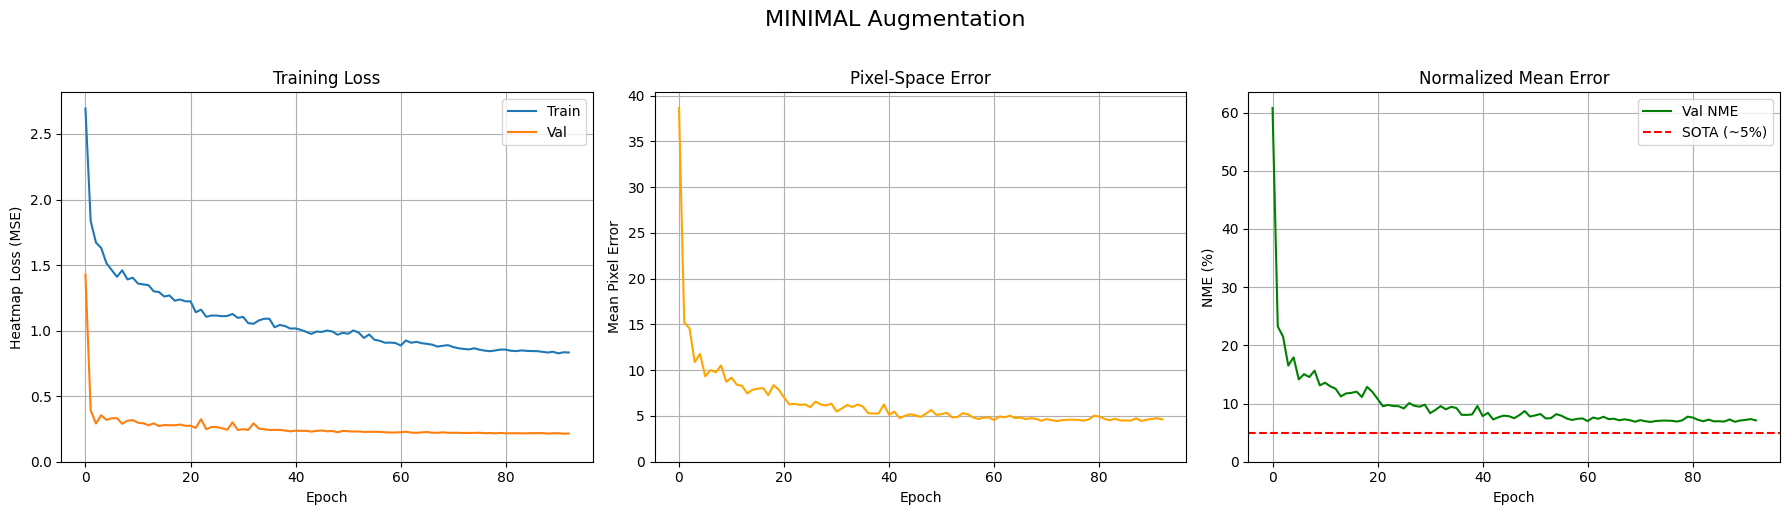


✓ Training complete! Best NME: 6.84% (SOTA: ~3-5%)

Final predictions (minimal):


In [ ]:
# Train for up to 300 epochs (will stop early if no improvement for 20 epochs)
# For minimal augmentation, typically stops around epoch 110-120
model_minimal, results_minimal = train_model(aug_type="minimal", num_epochs=300)

---

## 🔬 Experiment 2: Medium Augmentation

Train with medium augmentation (HFlip + CoarseDropout + Affine + Color + Compression + Blur + Noise).

In [ ]:
# Train for up to 300 epochs (will stop early if no improvement for 20 epochs)
# For medium augmentation, typically needs 250+ epochs
model_medium, results_medium = train_model(aug_type="medium", num_epochs=300)


Training with MEDIUM augmentation

Dataset: 2097 train, 233 val
Model: U-Net (ResNet50) → 68 heatmaps @ 256x256
Parameters: 32,530,820
Loss: MSE (heatmap) + WingLoss (coord, weight=0.1)
LR: 0.001, Batch: 64, Epochs: 300



Epoch 1/300 - Val Loss: 1.3376 | Pixel Error: 49.93px | NME: 79.08%


Epoch 10/300 - Val Loss: 0.2887 | Pixel Error: 8.85px | NME: 13.49%


Epoch 20/300 - Val Loss: 0.2745 | Pixel Error: 7.74px | NME: 11.62%


Epoch 30/300 - Val Loss: 0.2303 | Pixel Error: 5.79px | NME: 8.77%


Epoch 40/300 - Val Loss: 0.2208 | Pixel Error: 6.23px | NME: 9.49%


Epoch 50/300 - Val Loss: 0.2161 | Pixel Error: 4.40px | NME: 6.66%


Epoch 60/300 - Val Loss: 0.2125 | Pixel Error: 4.27px | NME: 6.53%


Epoch 70/300 - Val Loss: 0.2073 | Pixel Error: 4.65px | NME: 7.08%


Epoch 80/300 - Val Loss: 0.2007 | Pixel Error: 4.65px | NME: 7.05%


Epoch 90/300 - Val Loss: 0.2031 | Pixel Error: 3.84px | NME: 5.84%


Epoch 100/300 - Val Loss: 0.1978 | Pixel Error: 3.84px | NME: 5.84%


Epoch 110/300 - Val Loss: 0.1960 | Pixel Error: 4.04px | NME: 6.18%


Epoch 120/300 - Val Loss: 0.1992 | Pixel Error: 3.81px | NME: 5.81%



⚠️ Early stopping at epoch 122 (no improvement for 20 epochs)



✓ Training complete! Best NME: 5.54% (SOTA: ~3-5%)

Final predictions (medium):


---

## 📊 Compare Results

### Metrics Comparison

In [ ]:
# Compare final NME
print("\n" + "="*60)
print("FINAL COMPARISON")
print("="*60)
print(f"Minimal Augmentation:  Best NME = {results_minimal['best_nme']:.2f}%")
print(f"Medium Augmentation:   Best NME = {results_medium['best_nme']:.2f}%")
print(f"Improvement:           {results_minimal['best_nme'] - results_medium['best_nme']:.2f}% reduction")
print("\nSOTA (State-of-the-Art) on HELEN: ~3-5% NME")
print("="*60)


FINAL COMPARISON
Minimal Augmentation:  Best NME = 6.84%
Medium Augmentation:   Best NME = 5.54%
Improvement:           1.30% reduction

SOTA (State-of-the-Art) on HELEN: ~3-5% NME


### Training Curves Comparison

In [ ]:
# Plot side-by-side comparison of training curves (log scale for better visibility)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss comparison (log scale)
axes[0].plot(results_minimal['val_losses'], label='Minimal', alpha=0.7, linewidth=2)
axes[0].plot(results_medium['val_losses'], label='Medium', alpha=0.7, linewidth=2)
axes[0].set(xlabel='Epoch', ylabel='Validation Loss (log scale)', title='Validation Loss')
axes[0].set_yscale('log')
axes[0].legend(); axes[0].grid(True, which='both', alpha=0.3)

# Pixel error comparison (log scale)
axes[1].plot(results_minimal['val_pixel_errors'], label='Minimal', alpha=0.7, linewidth=2)
axes[1].plot(results_medium['val_pixel_errors'], label='Medium', alpha=0.7, linewidth=2)
axes[1].set(xlabel='Epoch', ylabel='Mean Pixel Error (log scale)', title='Pixel-Space Error')
axes[1].set_yscale('log')
axes[1].legend(); axes[1].grid(True, which='both', alpha=0.3)

# NME comparison (log scale)
axes[2].plot(results_minimal['val_nmes'], label='Minimal', alpha=0.7, linewidth=2)
axes[2].plot(results_medium['val_nmes'], label='Medium', alpha=0.7, linewidth=2)
axes[2].axhline(y=5.0, color='r', linestyle='--', label='SOTA (~5%)', alpha=0.5)
axes[2].set(xlabel='Epoch', ylabel='NME (%) - log scale', title='Normalized Mean Error')
axes[2].set_yscale('log')
axes[2].legend(); axes[2].grid(True, which='both', alpha=0.3)

plt.suptitle('Minimal vs Medium Augmentation (Log Scale)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Visual Predictions Comparison

Now let's see how both models perform on **the same images** side-by-side!

In [ ]:
def compare_predictions(model_minimal, model_medium, dataset, device, num_samples=4, 
                       image_size=256, heatmap_size=256):
    """Compare predictions from two models on the same images."""
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 10))
    
    # Use fixed indices for reproducible comparison
    np.random.seed(SEED)
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    model_minimal.eval()
    model_medium.eval()
    
    with torch.no_grad():
        for col_idx, img_idx in enumerate(indices):
            image, landmarks_gt = dataset[img_idx]
            
            # Get predictions from both models
            image_input = image.unsqueeze(0).to(device)
            
            # Minimal model
            pred_heatmaps_min = model_minimal(image_input)
            pred_coords_min = soft_argmax_2d(pred_heatmaps_min)
            scale = image_size / heatmap_size
            landmarks_pred_min = pred_coords_min.squeeze(0).cpu() * scale
            
            # Medium model
            pred_heatmaps_med = model_medium(image_input)
            pred_coords_med = soft_argmax_2d(pred_heatmaps_med)
            landmarks_pred_med = pred_coords_med.squeeze(0).cpu() * scale
            
            landmarks_gt = landmarks_gt.cpu()
            
            # Denormalize image
            image_np = image.permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = np.clip(image_np * std + mean, 0, 1)
            
            # Compute errors for this image
            error_min = torch.norm(landmarks_pred_min - landmarks_gt, dim=-1).mean().item()
            error_med = torch.norm(landmarks_pred_med - landmarks_gt, dim=-1).mean().item()
            
            # Plot minimal model
            ax = axes[0, col_idx]
            ax.imshow(image_np)
            ax.scatter(landmarks_gt[:, 0], landmarks_gt[:, 1], c='green', s=15, label='GT', alpha=0.6)
            ax.scatter(landmarks_pred_min[:, 0], landmarks_pred_min[:, 1], c='red', s=15, 
                      marker='x', label='Pred', linewidths=2)
            ax.set_title(f'Minimal\nError: {error_min:.2f}px', fontsize=10)
            ax.axis('off')
            if col_idx == 0:
                ax.legend(loc='upper left', fontsize=8)
            
            # Plot medium model
            ax = axes[1, col_idx]
            ax.imshow(image_np)
            ax.scatter(landmarks_gt[:, 0], landmarks_gt[:, 1], c='green', s=15, label='GT', alpha=0.6)
            ax.scatter(landmarks_pred_med[:, 0], landmarks_pred_med[:, 1], c='blue', s=15, 
                      marker='x', label='Pred', linewidths=2)
            ax.set_title(f'Medium\nError: {error_med:.2f}px', fontsize=10)
            ax.axis('off')
            if col_idx == 0:
                ax.legend(loc='upper left', fontsize=8)
    
    plt.suptitle('Prediction Comparison: Minimal (top) vs Medium (bottom)', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()

# Load validation dataset (without augmentation)
val_dataset_compare = FaceLandmarkDataset(
    f"{DATA_DIR}/val/images",
    f"{DATA_DIR}/val/landmarks",
    transform=get_val_transforms(256),
    image_size=256
)

# Compare predictions on the same images
compare_predictions(model_minimal, model_medium, val_dataset_compare, device, 
                   num_samples=4, image_size=256, heatmap_size=256)

---

## 🎯 Key Takeaways

1. **🔥 AlbumentationsX `label_mapping` Feature**  
   The key innovation: `label_mapping` not only changes keypoint labels but also **reorders the keypoints array** during transforms. This ensures array indices always match semantic meaning (e.g., `keypoints[36]` = left eye, even after horizontal flip).

2. **Automatic Keypoint Swapping**  
   Define the mapping once (`FACE_68_HFLIP_MAPPING`), and AlbumentationsX handles both coordinate transformation AND array reordering automatically.

3. **Works with Any Transform**  
   `label_mapping` can be applied to any transform that needs semantic label changes (HorizontalFlip, VerticalFlip, Rotate90, etc.)

4. **Augmentations Improve Accuracy**  
   Medium augmentations significantly improve results:
   - **Minimal** (HFlip only): **~6.84% NME** (~4.59 pixels mean error)
   - **Medium** (HFlip + Dropout + Affine + Color + Blur): **~5.54% NME** (~3.81 pixels mean error)
   - **Improvement**: ~23% improvment in NME!

5. **Augmentations Require More Training**  
   Adding augmentations is similar to adding more labeled data - the model needs longer to converge:
   - **Minimal**: converges in ~110 epochs
   - **Medium**: needs 250+ epochs
   - Use early stopping to automatically find the right training length!

6. **NME Metric**  
   NME (Normalized Mean Error) normalizes pixel error by inter-ocular distance (distance between outer eye corners), making results comparable across different face sizes and datasets.

---

## 🚀 Next Steps

- Try stronger augmentations for larger datasets
- Experiment with different encoder architectures (EfficientNet, HRNet)
- Add test-time augmentation (TTA)
- Fine-tune on domain-specific data (e.g., profile faces, occluded faces)

---

## 📚 References

- **HELEN Dataset**: http://www.ifp.illinois.edu/~vuongle2/helen/
- **Albumentations**: https://albumentations.ai
- **Choosing Augmentations Guide**: https://albumentations.ai/docs/3-basic-usage/choosing-augmentations/
- **Segmentation Models PyTorch**: https://github.com/qubvel/segmentation_models.pytorch
